In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import dataset_utils
from Utils import MAPE, RMSELoss, EarlyStopper
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
from numpy.lib.stride_tricks import sliding_window_view
from sklearn.model_selection import train_test_split, TimeSeriesSplit
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.nn import MSELoss
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import itertools
from collections import defaultdict
from sklearn.compose import TransformedTargetRegressor


/home/grinenko/anaconda3/envs/anna/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
def global_seed(seed=42):
    # random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

SEED = 42    
global_seed(seed=SEED)

In [6]:
soft = ['35_21_1000.Q.KatKlD.1444.octanI', '35_21_1000.Q.KatKlAB.DavNpar', '35_21_1000.Q.KatKlAB.EBen70', '35_21_1000.Q.KatKlAB.AroPf.v']
short_name = {'35_21_1000.Q.KatKlD.1444.octanI': 'octanI', 
              '35_21_1000.Q.KatKlAB.DavNpar' : 'DavNpar', 
              '35_21_1000.Q.KatKlAB.EBen70': 'Eben70', 
              '35_21_1000.Q.KatKlAB.AroPf.v' : 'AroPfv'
}

In [7]:
K = 120 #усреднение
SOFT_SENSOR_INDEX = 2
SOFT_SENSOR_NAME = soft[SOFT_SENSOR_INDEX]
MODEL_PATH = f"./models/{short_name[SOFT_SENSOR_NAME]}.pth"
PERIODS_FILE = "periods_W20_gr120_Agl.npy"

In [8]:
data = pd.read_csv("Dataset1_nans.csv", sep=";")

In [9]:
data.head()

,Timestamp,35_21_1000.Q.KatKlAB.AroPf.v,35_21_1000.Q.KatKlAB.DavNpar,35_21_1000.Q.KatKlAB.EBen70,35_21_1000.Q.KatKlD.1444.octanI,35_21_1000_FC_3122,35_21_1000_FC_321.SP,35_21_1000_FI_3101,35_21_1000_FI_3130,35_21_1000_FI_326,...,35_21_1000_TI_3305,35_21_1000_TI_3581,CCR_CCR300_CV_3DT_H1_VAL,CCR_CCR300_CV_DT_R12_VAL,CCR_CCR300_CV_DT_R23_VAL,CCR_CCR300_CV_DT_R34_VAL,CCR_CCR300_CV_DT_R41_VAL,CCR_CCR300_CV_FI_3101PTC_VAL,CCR_CCR300_CV_PC_3180_OP_VAL,CCR_CCR300_CV_WAIT_SP_VAL
0,01.01.2016 00:00:00,65.59,48.0,6.0,98.9,33.61328,194.0002,59.90619,2798.065,50.50889,...,134.7649,25.61035,90.86990,-3.72980,-7.13281,-1.0,11.86261,59.14596,70.77777,519.1353
1,01.01.2016 00:01:00,NaN,NaN,NaN,NaN,33.77030,194.0002,60.26051,2826.544,50.86543,...,134.8389,25.61035,90.90942,-3.72989,-7.13306,-1.0,11.86295,59.18106,70.93322,519.1353
2,01.01.2016 00:02:00,NaN,NaN,NaN,NaN,33.86683,194.0002,60.16202,2817.218,50.76682,...,134.6192,25.61055,90.88013,-3.73050,-7.13440,-1.0,11.86490,59.16980,70.03181,519.1346
3,01.01.2016 00:03:00,NaN,NaN,NaN,NaN,34.00380,194.0002,60.28071,2806.594,50.84354,...,134.6191,25.63477,90.87057,-3.73145,-7.13660,-1.0,11.86804,59.30387,70.46443,519.1337
4,01.01.2016 00:04:00,NaN,NaN,NaN,NaN,33.70545,194.0002,59.33250,2774.242,50.95883,...,134.6191,25.63477,90.90518,-3.73212,-7.13818,-1.0,11.87030,59.26101,69.81942,519.1330


In [10]:
soft_data = data[soft].copy()

In [11]:
soft_data.shape

(2040480, 4)

In [12]:
data_orig = data.drop(soft + ['Timestamp'], axis=1)

In [13]:
data_orig.head()

,35_21_1000_FC_3122,35_21_1000_FC_321.SP,35_21_1000_FI_3101,35_21_1000_FI_3130,35_21_1000_FI_326,35_21_1000_LC_208.OP,35_21_1000_LC_3116.OP,35_21_1000_PC_1214,35_21_1000_PC_3123,35_21_1000_PC_3123.OP,...,35_21_1000_TI_3305,35_21_1000_TI_3581,CCR_CCR300_CV_3DT_H1_VAL,CCR_CCR300_CV_DT_R12_VAL,CCR_CCR300_CV_DT_R23_VAL,CCR_CCR300_CV_DT_R34_VAL,CCR_CCR300_CV_DT_R41_VAL,CCR_CCR300_CV_FI_3101PTC_VAL,CCR_CCR300_CV_PC_3180_OP_VAL,CCR_CCR300_CV_WAIT_SP_VAL
0,33.61328,194.0002,59.90619,2798.065,50.50889,32.18112,73.18839,335.2588,0.90149,39.16984,...,134.7649,25.61035,90.86990,-3.72980,-7.13281,-1.0,11.86261,59.14596,70.77777,519.1353
1,33.77030,194.0002,60.26051,2826.544,50.86543,32.12791,73.41551,334.5651,0.90200,39.17371,...,134.8389,25.61035,90.90942,-3.72989,-7.13306,-1.0,11.86295,59.18106,70.93322,519.1353
2,33.86683,194.0002,60.16202,2817.218,50.76682,32.20516,73.24171,334.8679,0.90140,39.17712,...,134.6192,25.61055,90.88013,-3.73050,-7.13440,-1.0,11.86490,59.16980,70.03181,519.1346
3,34.00380,194.0002,60.28071,2806.594,50.84354,32.09575,73.27421,335.3974,0.90125,39.17995,...,134.6191,25.63477,90.87057,-3.73145,-7.13660,-1.0,11.86804,59.30387,70.46443,519.1337
4,33.70545,194.0002,59.33250,2774.242,50.95883,32.10447,73.46095,334.3661,0.90098,39.18215,...,134.6191,25.63477,90.90518,-3.73212,-7.13818,-1.0,11.87030,59.26101,69.81942,519.1330


In [14]:
# selector = VarianceThreshold(0.001)
# dataset1 = selector.fit_transform(data_orig)
# dataset1.shape

In [15]:
data.shape, data_orig.shape

((2040480, 62), (2040480, 57))

In [16]:
rmse = RMSELoss()
METRICS = {'rmse': rmse, 'r2':r2_score}

array([[<AxesSubplot:title={'center':'35_21_1000.Q.KatKlD.1444.octanI'}>,
        <AxesSubplot:title={'center':'35_21_1000.Q.KatKlAB.DavNpar'}>],
       [<AxesSubplot:title={'center':'35_21_1000.Q.KatKlAB.EBen70'}>,
        <AxesSubplot:title={'center':'35_21_1000.Q.KatKlAB.AroPf.v'}>]],
      dtype=object)

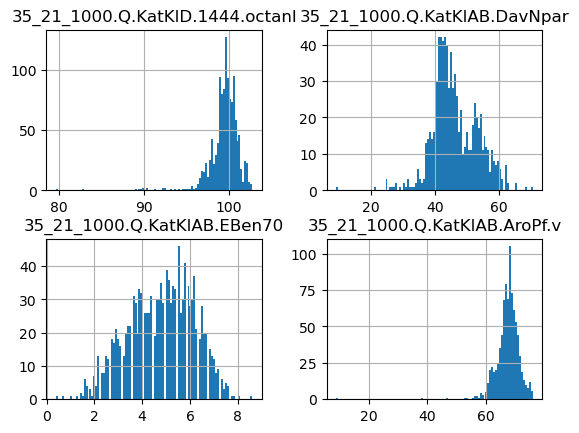

In [17]:
soft_data.hist(bins=100)

In [18]:
class LSTM_Model(nn.Module):
    def __init__(self, hidden_size=2):
        super(LSTM_Model, self).__init__()
        self.layer1 = nn.LSTM(input_size=features_num, hidden_size=hidden_size, num_layers=1, batch_first=True)
        self.layer2 = nn.Linear(in_features=hidden_size, out_features=1)
        

    def forward(self, x):
        x, _ = self.layer1(x) #out, cell
        x = x[:, -1, :]
        x = self.layer2(x)
        return x.reshape(-1,)
    

In [19]:
class Conv_LSTM_Model(nn.Module):
    def __init__(self, in_channels=30, convs_config=(10), hidden_size=50, num_features=59):
        super(Conv_LSTM_Model, self).__init__()
#         convs = []
#         channels = [[in_channels]] + list(convs_config)
#         for i, conv in enumerate(convs_config):
#             convs.append(nn.Conv1d(channels[i][0], channels[i + 1][0], kernel_size=channels[i + 1][1]))
#             if i != len(convs_config) - 1:
#                 convs.append(nn.ReLU(inplace=True))
#         self.convolutions = nn.Sequential(convs)
#         self.convolutions = nn.Sequential(
#             nn.Conv2d(in_channels, in_channels * 2, kernel_size=5), #(2 * in, in - k)
#             nn.ReLU(inplace=True),
#             nn.Conv1d(in_channels * 2, in_channels, kernel_size=5) #(in, in - 2 * k)
#         )
        self.conv = nn.Conv1d(num_features, 2 * num_features, kernel_size=5, stride=2) #(B, 10, )
        self.lstm = nn.LSTM(input_size=2 * num_features, hidden_size=hidden_size, num_layers=1, batch_first=True)
        self.linear = nn.Linear(in_features=hidden_size, out_features=1)
        

    def forward(self, x):
        x = x.transpose(2, 1)
        x = self.conv(x)
        x = x.transpose(2, 1)
        x, _ = self.lstm(x) #out, cell
        x = x[:, -1, :]
        x = self.linear(x)
        return x.reshape(-1,)

In [20]:
dataset = dataset_utils.Dataset(data_orig, soft_data[SOFT_SENSOR_NAME], delay=0, K=K, diff=False)
dataset_x, dataset_y, scaler_y = dataset.window_view(W=30, scale_target=False)


(1275, 30, 57) (1279,)


In [21]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda', 1)

print(type(device), device)

<class 'torch.device'> cuda:1


In [22]:
def format_print(row):
    if isinstance(row, list):
        for r in row:
            format_print(r)
        return
    train, valid, test = row[1].values()
    print(*row[0])
    for mode in row[1].keys():
        print(f"     {mode:6}: ", end="")
        for metric_type, value in row[1][mode].items():
            print(f"{metric_type} = {value:.03}, ", end="")
        print()
#     print(f"\n     K, W, bs - {row[0]} |\ntrain {train[0]:.3}, {train[1]:.3}, {train[1]:.3} \nvalid {valid[0]:.3}, {valid[1]:.3}, {valid[1]:.3} \ntest {test[0]:.3}, {test[1]:.3}, {test[2]:.3} \n")

In [23]:
def r2_score(target, output):
    if not torch.is_tensor(target):
        target = torch.tensor(target)
    if not torch.is_tensor(output):
        output = torch.tensor(output)
    target_mean = torch.mean(target)
    ss_tot = torch.sum(torch.square(target - target_mean))
    ss_res = torch.sum(torch.square(target - output))
    r2 = 1 - ss_res / ss_tot
    return r2

In [24]:
def apply_model(model, data_x, scaler=None):
    model.eval()
    with torch.no_grad():
        if not torch.is_tensor(data_x):
            data_x = torch.tensor(data_x)
        inputs = data_x.float()
        outputs = model(inputs)
    if scaler is not None:
        outputs = scaler.inverse_transform(outputs)
    return outputs

In [25]:
def train_one_epoch(train_dataloader, model, loss_fn, optimizer):
    model.train()
    for batch in train_dataloader:
        inputs, targets = batch
        inputs = inputs.float()
        targets = targets.float()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
    return loss

In [26]:
def trainingCV(X, y, model=None, model_args=None, epoches=1, loss_fn=MSELoss(), \
             optimizer=None, batch_size=8, device='cpu', n_folds=5, train_size_in_folds=3, y_scaler=None, tables_path=None):
#     X, y = [torch.tensor(tmp).to(device) for tmp in (X, y)]
    CV_splitter = TimeSeriesSplit(n_splits=n_folds - 1, max_train_size=int(train_size_in_folds/n_folds * X.shape[0]))
    losses = {x:defaultdict(list) for x in ('train', 'valid', 'test')}
    splitter = iter(CV_splitter.split(X))
    for i in range(train_size_in_folds - 1):
        next(splitter); 
    for i, (train_inds, test_inds) in enumerate(splitter):
        print("______________")
        train_x, train_y, test_x, test_y = X[train_inds], y[train_inds], X[test_inds], y[test_inds]
        train_inds, valid_inds = train_test_split(train_inds, test_size=0.2, shuffle=False)
        train_x, valid_x, train_y, valid_y = X[train_inds], X[valid_inds], y[train_inds], y[valid_inds]
        print(f"train {train_x.shape}, valid {valid_x.shape}, test {test_x.shape}")
        #train
        train_dataloader = DataLoader([x for x in zip(train_x, train_y)], batch_size=batch_size, shuffle=True)
        cur_model = model(**model_args)
        train_losses, trained_model = training(train_x, train_y, valid_x, valid_y, model=cur_model, epoches=epoches, loss_fn=loss_fn, \
                               optimizer=optimizer, batch_size=batch_size, device=device)
        #test
        test_output = apply_model(trained_model, test_x, scaler=None)
#         plt.hist(torch.abs(test_y - test_output))
#         plt.show()
        for metric_type, metric_func in METRICS.items():
            losses['test'][metric_type].append(metric_func(test_y, test_output))
            losses['train'][metric_type].append(train_losses['train'][metric_type])
            losses['valid'][metric_type].append(train_losses['valid'][metric_type])
        if tables_path is not None:
            write_table(trained_model, X, y, mask_train=train_inds, mask_valid=valid_inds, mask_test=test_inds, \
                        num_fold=i, y_scaler=y_scaler, path=tables_path)
#     for (mode, dct) in losses.items():
#         for (loss_type, lst) in dct.items():
#             dct[loss_type] = np.mean(lst)
    return losses, trained_model


In [27]:
def training(train_x, train_y, test_x, test_y, model=None, epoches=1, loss_fn=MSELoss(), \
             optimizer=None, batch_size=8, device='cpu', path_log=None, y_scaler=None):
    train_x, train_y, test_x, test_y = [torch.tensor(tmp).to(device) for tmp in (train_x, train_y, test_x, test_y)]
    train_dataloader = DataLoader([x for x in zip(train_x, train_y)], batch_size=batch_size, shuffle=True)
    if optimizer == None:
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)#, momentum=0.8)
    early_stopper = EarlyStopper(patience=20, min_delta=0, start_from_epoch=10, path=f"baseline_results/model_{SOFT_SENSOR_INDEX}")
    model.to(device)
    losses = {x:defaultdict(list) for x in ('train', 'valid', 'test')}
    best_epoch = epoches
    for epoch in range(epoches):
        #train
        loss = train_one_epoch(train_dataloader, model, loss_fn, optimizer)
        #valid
        train_output = apply_model(model, train_x, scaler=None)
        test_output = apply_model(model, test_x, scaler=None)
#         test_result = sc_y.inverse_transform(test_output.reshape(-1, 1)).reshape(-1)
        for metric_type, metric_func in METRICS.items():
            losses['train'][metric_type].append(metric_func(train_y, train_output))
            losses['valid'][metric_type].append(metric_func(test_y, test_output))
            
        if early_stopper.early_stop(losses['valid']['rmse'][-1], model):
            best_epoch = early_stopper.min_loss_epoch_number
            print(f"Early stopping, epochs {epoch}, best epoch {best_epoch}: R2 = {losses['valid']['r2'][best_epoch - 1]}")
            model = early_stopper.restore_model(model)
            break
        #
        if epoch % 10 == 0:
            print("Epoch %d: train RMSE %.4f, valid RMSE %.4f, valid R2 %.4f\n" % (epoch, losses['train']['rmse'][-1], losses['valid']['rmse'][-1], losses['valid']['r2'][-1]))
    #TODO save losses during epoches with path_log
    plt.plot(losses['valid']['rmse'], label='valid')
    plt.plot(losses['train']['rmse'], label='train')
    plt.legend()
    plt.show()
    for (mode, dct) in losses.items():
        for (loss_type, lst) in dct.items():
            dct[loss_type] = lst[best_epoch - 1]
    return losses, model

In [28]:
def write_table(R, dataset_x, dataset_y, mask_train=None, mask_test=None, mask_valid=None, path=None, num_fold=0, y_scaler=None):
    y_pred = apply_model(R, dataset_x)
    if y_scaler is not None:
        y_pred = y_scaler.inverse_transform(y_pred)
        dataset_y = y_scaler.inverse_transform(dataset_y)
    mask = np.zeros(dataset_x.shape[0])
    mask[:] = 2
    mask[mask_train] = 0 #TRAIN
    if mask_valid is not None:
        mask[mask_valid] = 1 # VALID
    mask[mask_test] = 2 #TEST
    path = f"baseline_results/table_{SOFT_SENSOR_INDEX}_{num_fold}---{path if path is not None else ''}.csv"
    table = pd.DataFrame(np.stack((dataset_y, y_pred, mask), axis=1), \
                         columns= ['y', 'y_pred', 'mode'])
    table.to_csv(path)

In [29]:
from time import time

In [30]:
start = time()
start

1703138537.4905953

(1033, 16, 57) (1033,)
______________
train (472, 16, 57), valid (118, 16, 57), test (147, 16, 57)
Epoch 0: train RMSE 0.8725, valid RMSE 0.9335, valid R2 -0.1924

Epoch 10: train RMSE 0.5624, valid RMSE 0.7359, valid R2 0.2588

Epoch 20: train RMSE 0.5022, valid RMSE 0.7684, valid R2 0.1919

Epoch 30: train RMSE 0.4478, valid RMSE 0.7981, valid R2 0.1282

Early stopping, epochs 31, best epoch 11: R2 = 0.2588482446052145


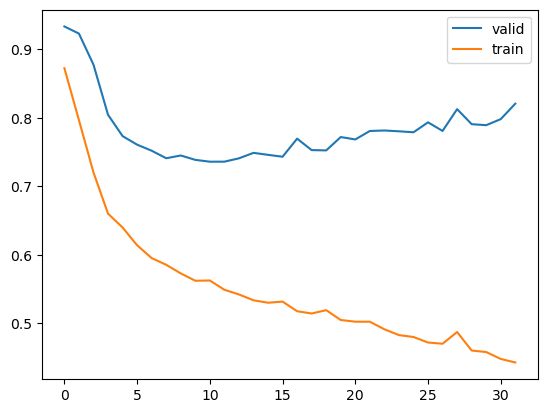

______________
train (472, 16, 57), valid (118, 16, 57), test (147, 16, 57)
Epoch 0: train RMSE 0.8106, valid RMSE 1.0666, valid R2 -0.5162

Epoch 10: train RMSE 0.5535, valid RMSE 0.6365, valid R2 0.4601

Epoch 20: train RMSE 0.5057, valid RMSE 0.5997, valid R2 0.5207

Epoch 30: train RMSE 0.4534, valid RMSE 0.6151, valid R2 0.4957

Epoch 40: train RMSE 0.4026, valid RMSE 0.6110, valid R2 0.5025

Epoch 50: train RMSE 0.3348, valid RMSE 0.5847, valid R2 0.5444

Epoch 60: train RMSE 0.2904, valid RMSE 0.5821, valid R2 0.5484

Epoch 70: train RMSE 0.2616, valid RMSE 0.5677, valid R2 0.5706

Epoch 80: train RMSE 0.2169, valid RMSE 0.5773, valid R2 0.5558

Early stopping, epochs 88, best epoch 68: R2 = 0.5856034072949786


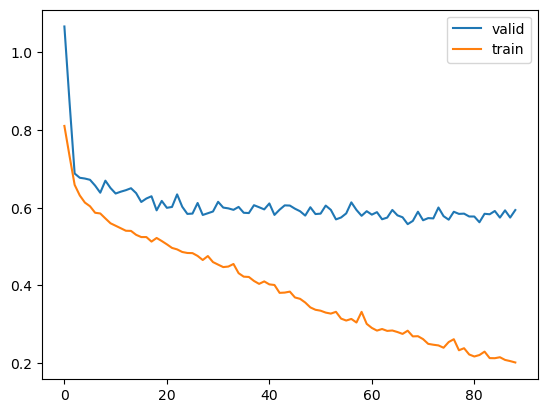

______________
train (472, 16, 57), valid (118, 16, 57), test (147, 16, 57)
Epoch 0: train RMSE 0.8020, valid RMSE 0.9919, valid R2 -0.0014

Epoch 10: train RMSE 0.5424, valid RMSE 0.6356, valid R2 0.5888

Epoch 20: train RMSE 0.4766, valid RMSE 0.6024, valid R2 0.6306

Epoch 30: train RMSE 0.4192, valid RMSE 0.5856, valid R2 0.6510

Epoch 40: train RMSE 0.3725, valid RMSE 0.5645, valid R2 0.6757

Epoch 50: train RMSE 0.3456, valid RMSE 0.5700, valid R2 0.6693

Epoch 60: train RMSE 0.2886, valid RMSE 0.5732, valid R2 0.6656

Early stopping, epochs 69, best epoch 49: R2 = 0.7024799142952345


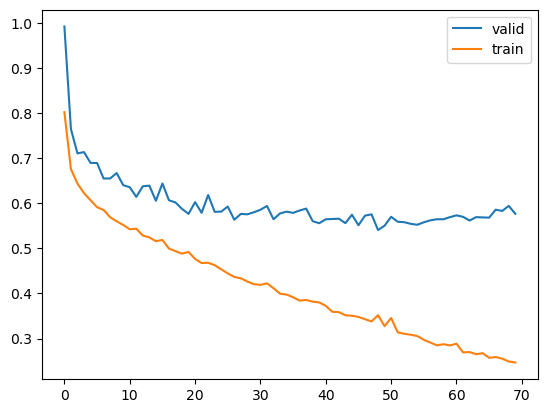

In [31]:
Ks = [120]#[60, 120, 240]
Ws = [16] #[8, 16, 32] 
batch_size = [4] #[8, 16] #[4, 8] 
results_str = ""
res = defaultdict(dict)
EPOCHES = 150
y_scaler = None
best_model = None
global_seed(SEED)
for K in Ks:
    PERIODS_FILE = "periods_W20_gr{}_Agl.npy".format(K)
    dataset = dataset_utils.Dataset(data_orig, soft_data[SOFT_SENSOR_NAME], delay=0, K=K, diff=False, periods=PERIODS_FILE)
    for W in Ws:
        dataset_x, dataset_y, _ = dataset.window_view(W=W, scale_target=False)
        y_scaler = dataset_utils.MyStandardScaler()
        dataset_y = y_scaler.fit_transform(dataset_y)
        assert(dataset_x.shape[0] == dataset_y.shape[0])
        features_num = dataset_x.shape[-1]
#         train_x, test_x, train_y, test_y = train_test_split(dataset_x, dataset_y, test_size=0.30, shuffle=False, random_state=SEED)
#         train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.17, shuffle=False, random_state=SEED)
#         if y_scaler is not None:
#             restored_train_y, restored_valid_y, restored_test_y = [scaler_y.inverse_transform(tmp) for tmp in (train_y, valid_y, test_y)]
        model_args = {'hidden_size':100}
        for bs in batch_size:
            losses, model = trainingCV(dataset_x, dataset_y, model=LSTM_Model, model_args=model_args, \
                     epoches=EPOCHES, batch_size=bs, n_folds=7, y_scaler=y_scaler, train_size_in_folds=4, \
                    tables_path="try3")
#             best_model = LSTM_Model(**model_args)
#             best_model.load_state_dict(torch.load(MODEL_PATH))
            
#             res[K][(W, bs)] = {'train': (train_rmse, train_r2, train_mape), 'valid': (valid_rmse, valid_r2, valid_mape), 'test':(test_rmse, test_r2, test_mape)}
            res[K][(W, bs)] = losses

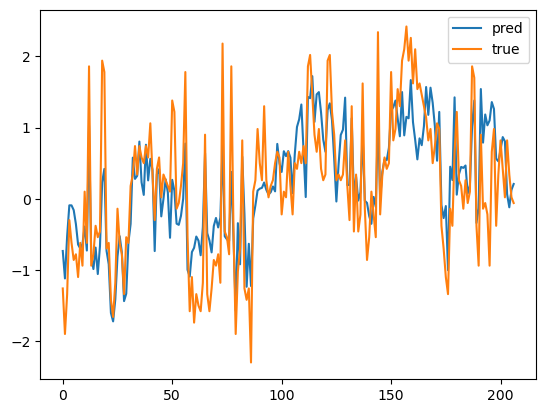

In [32]:
_, test_x, _, test_y = train_test_split(dataset_x, dataset_y, test_size=0.2, shuffle=False)
y_pred = apply_model(model, test_x)
plt.plot(y_pred, label='pred')
plt.plot(test_y, label='true')
plt.legend()
plt.show()

In [33]:
fin = time()

In [34]:
(fin - start) // 60

1.0

In [35]:
# len(value['test']['r2'])

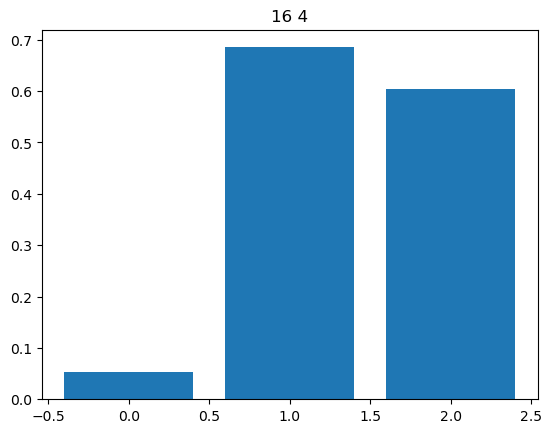

In [36]:
n = 3
for (K, dct) in res.items():
    for (param, value) in dct.items():
        plt.bar(np.arange(n), [x for x in value['test']['r2']]) 
        plt.title(" ".join([str(x) for x in param]))
        plt.show()

In [37]:
for K in res.keys():
    for (param, losses) in res[K].items():
        for (mode, dct) in losses.items():
            for (loss_type, lst) in dct.items():
                dct[loss_type] = np.mean(lst)

In [38]:
best = {}
for K in res.keys():
    print("\nK =", K)
    tmp = sorted(res[K].items(), key=lambda x: x[1]['valid']['rmse'], reverse=False)[0]
    best[K] = tmp
    format_print(tmp)
print("\n\n")
top = sorted(best.items(), key=lambda x: x[1][1]['test']['rmse'], reverse=False)[0]
format_print((tuple([top[0]]) + top[1][0], top[1][1]))
# format_print(sorted(best, key=lambda x: x[1]['test'][1], reverse=True)[:1])
# format_print(sorted(best, key=lambda x: x[1]['test'][2], reverse=False)[0])


K = 120
16 4
     train : rmse = 0.399, r2 = 0.781, 
     valid : rmse = 0.611, r2 = 0.516, 
     test  : rmse = 0.683, r2 = 0.447, 



120 16 4
     train : rmse = 0.399, r2 = 0.781, 
     valid : rmse = 0.611, r2 = 0.516, 
     test  : rmse = 0.683, r2 = 0.447, 
